In [2]:
!pip install mne
!pip install tensorflow==2.9.1

      Successfully uninstalled tensorflow-2.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.3 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.


In [1]:
import tensorflow as tf
import pywt
print(tf.__version__)
from mne.decoding import CSP

2.9.1


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from IPython.display import clear_output
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler,Normalizer,MinMaxScaler
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
'''train_data = pd.read_csv('/content/drive/MyDrive/TCC-Physionet/PhysionetTrainSub1_30.csv', delimiter=";")
test_data = pd.read_csv('/content/drive/MyDrive/TCC-Physionet/PhysionetTestSub1_30.csv', delimiter=";")
val_data = pd.read_csv('/content/drive/MyDrive/TCC-Physionet/PhysionetValSub1_30.csv', delimiter=";")
'''
train_data = pd.read_csv('/content/drive/MyDrive/TCC-Physionet/PhysionetTrain.csv', delimiter=";")
test_data = pd.read_csv('/content/drive/MyDrive/TCC-Physionet/PhysionetTest.csv', delimiter=";")
val_data = pd.read_csv('/content/drive/MyDrive/TCC-Physionet/PhysionetVal.csv', delimiter=";")



In [4]:
labels = {'0': 'rest', '1': 'left', '2': 'right'}
selected_eletrodes = ['CZ', 'FZ', 'T7', 'P7', 'C3', 'P3', 'FC3', 'CP3', 'T8','P8','C4','P4','FC4','CP4']
 # list(train_data['eletrodo'].unique())
 #['C3', 'CZ', 'C4']
 #
 #['F3', 'F4', 'F5', 'F6', 'FC5', 'FC3','FC4', 'FC6', 'C5', 'C3', 'C4', 'C6']

In [5]:
teste_futuro =  ['FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8',
 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8',
 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8',
 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8']

In [6]:
# y_delta = butter_bandpass_filter(signal, 0.1, 4, 160, order=5)
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs=160, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def wavelet_denoising(x, wavelet='db2', level=3):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

In [45]:
def metrics_zscore(data, selected_eletrodes):
  std = []
  mean = []
  for eletrode in selected_eletrodes:
    eletrodoStd = pd.Series(data.loc[data["eletrodo"] == eletrode, "leitura0":"leitura639"].values.ravel('F')).std()
    eletrodoMean = pd.Series(data.loc[data["eletrodo"] == eletrode, "leitura0":"leitura639"].values.ravel('F')).mean()
    std.append(eletrodoStd)
    mean.append(eletrodoMean)

  return std, mean

def madev(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='db2', level=3):
  coeff = pywt.wavedec(x, wavelet, mode="per")
  sigma = (1/0.6745) * madev(coeff[-level])
  uthresh = sigma * np.sqrt(2 * np.log(len(x)))
  coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
  return pywt.waverec(coeff, wavelet, mode='per')

def normalize_fit(data, norm):
  for i in range(len(data)):
    norm = norm.fit(data[i])
  return norm

def normalize_transform(data, norm):
  transformed_data = np.zeros([len(data),640,14])
  for i in range(len(data)):
      transformed_data[i] = norm.transform(data[i]).T.astype(np.float32)
  return transformed_data

def high_pass_filter(data, cutoff_frequency=0.1):
  b, a = signal.butter(1, cutoff_frequency, btype='highpass')
  filtered_data = signal.lfilter(b, a, data)
  return filtered_data


In [46]:
def assemble_data(data, selected_eletrodes):
  labels = []
  signals = []
  pacients = data["paciente"].unique()
  len_selected_eletrodes = len(selected_eletrodes)

  for pacient in pacients:
      measures = data.loc[data['paciente'] == pacient]['medicao'].unique()
      for measure in measures:
          label = data.loc[(data['paciente'] == pacient) & (data['medicao'] == measure)]['label'].unique()[0]
          if label != 1:
            img = np.zeros([len_selected_eletrodes, 640])
            print(pacient,measure)
            for idx, eletrode in enumerate(selected_eletrodes):
              img[idx] = data.loc[(data['paciente'] == pacient) & (data['medicao'] == measure) & (data['eletrodo'] == eletrode)].iloc[:,4:644].to_numpy()
            signals.append(img)
            labels.append(label-2)
            clear_output(wait=True)
  return labels, signals


In [47]:
class PhysionetDataset:
  def __init__(self, trainData, valData, testData, selected_eletrodes, batch_size):

    self.trainLabel, self.trainSignal = assemble_data(trainData, selected_eletrodes)
    self.valLabel, self.valSignal = assemble_data(valData, selected_eletrodes)
    self.testLabel, self.testSignal = assemble_data(testData, selected_eletrodes)

    #self.trainSignal = butter_bandpass_filter(self.trainSignal, 0.1, 30, 160, order=5)
    #self.valSignal = butter_bandpass_filter(self.valSignal, 0.1, 30, 160, order=5)
    #self.testSignal = butter_bandpass_filter(self.testSignal, 0.1, 30, 160, order=5)

    #self.trainSignal = wavelet_denoising(self.trainSignal)
    #self.valSignal = wavelet_denoising(self.valSignal)
    #self.testSignal = wavelet_denoising(self.testSignal)

    normMinMax = MinMaxScaler()
    normMinMax = normalize_fit(self.trainSignal, normMinMax)
    normMinMax = normalize_fit(self.valSignal, normMinMax)
    normMinMax = normalize_fit(self.testSignal, normMinMax)

    self.trainSignal = normalize_transform(self.trainSignal, normMinMax)
    self.valSignal = normalize_transform(self.valSignal, normMinMax)
    self.testSignal = normalize_transform(self.testSignal, normMinMax)

    img_generator = tf.keras.preprocessing.image.ImageDataGenerator()

    self.TrainDataset = img_generator.flow(
        x=np.array(self.trainSignal).reshape(len(self.trainSignal), 640, 14, 1),
        y=np.array(self.trainLabel).reshape(len(self.trainLabel),1),
        batch_size=batch_size)

    self.ValDataset = img_generator.flow(
        x=np.array(self.valSignal).reshape(len(self.valSignal), 640, 14, 1),
        y=np.array(self.valLabel).reshape(len(self.valLabel),1),
        batch_size=batch_size)

    self.TestDataset = img_generator.flow(
        x=np.array(self.testSignal).reshape(len(self.testSignal), 640, 14, 1),
        y=np.array(self.testLabel).reshape(len(self.testLabel),1),
        batch_size=batch_size)


In [48]:
batch = 32

physionetDataset = PhysionetDataset(train_data, val_data, test_data, selected_eletrodes, batch)

108 87


In [27]:
print(physionetDataset.TrainDataset.x.shape)
print(physionetDataset.ValDataset.x.shape)
print(physionetDataset.TestDataset.x.shape)

(2836, 14, 640, 1)
(623, 14, 640, 1)
(591, 14, 640, 1)


In [49]:
'''inp = layers.Input(shape=(14, 640, 1))
x = layers.Conv2D(8, (2,2), padding= 'same')(inp)
x = layers.Conv2D(16, (2,2), activation=layers.LeakyReLU(0.1), strides=(1,2))(x)
x = layers.Conv2D(32, (2,2), padding= 'same')(x)

x = layers.MaxPool2D((2,2))(x)
x = layers.Dropout(0.1)(x)
x = layers.Conv2D(64, (1,2), activation=layers.LeakyReLU(0.1), padding= 'same')(x)
x = layers.Conv2D(128, (1,2), activation=layers.LeakyReLU(0.1), padding= 'same')(x)


x = layers.MaxPool2D((2,2))(x)
x = layers.Dropout(0.1)(x)
x = layers.Conv2D(512, (1,2), activation=layers.LeakyReLU(0.1), padding= 'same')(x)
x = layers.Conv2D(1024, (1,2), activation=layers.LeakyReLU(0.1), padding= 'same')(x)


#x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(inp, x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,),loss=tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])#,'mse', 'AUC'])
'''
model = tf.keras.Sequential()
model.add(layers.Conv2D(128, (3, 3), padding="same", input_shape=(640, 14, 1), activation=layers.LeakyReLU(0.1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(256, (3, 3), padding="same", activation=layers.LeakyReLU(0.1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(256, (3, 3), padding="same", activation=layers.LeakyReLU(0.1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(128, (3, 3), padding="same", activation=layers.LeakyReLU(0.1)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())

model.add(layers.Dense(64, activation=layers.LeakyReLU(0.1)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation="sigmoid"))

learning_rate = 0.0005
decay_rate = learning_rate / 50
momentum = 0.8

sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)
#rms = layers.RMSprop(lr=learning_rate, rho=0.9)
adam = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model.compile(optimizer = sgd, loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])#,'mse', 'AUC'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 640, 14, 128)      1280      
                                                                 
 batch_normalization_30 (Bat  (None, 640, 14, 128)     512       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 320, 7, 128)      0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 320, 7, 128)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 320, 7, 256)       295168    
                                                                 
 batch_normalization_31 (Bat  (None, 320, 7, 256)     

In [50]:
#model = load_model('/content/drive/MyDrive/TCC-Physionet/model_CNNEEG.h5')

history = model.fit(physionetDataset.TrainDataset.x, physionetDataset.TrainDataset.y, epochs=50, validation_data=(physionetDataset.ValDataset.x, physionetDataset.ValDataset.y))#, callbacks=callbacks)

model.save('/content/drive/MyDrive/TCC-Physionet/model_CNNEEG.h5')

Epoch 1/50
89/89 [==============================] - 4s 26ms/step - loss: 0.9397 - accuracy: 0.5448 - val_loss: 0.6939 - val_accuracy: 0.4944
Epoch 2/50
89/89 [==============================] - 2s 21ms/step - loss: 0.7847 - accuracy: 0.6033 - val_loss: 0.6948 - val_accuracy: 0.5136
Epoch 3/50
89/89 [==============================] - 2s 21ms/step - loss: 0.7075 - accuracy: 0.6664 - val_loss: 0.6492 - val_accuracy: 0.6421
Epoch 4/50
89/89 [==============================] - 2s 21ms/step - loss: 0.6171 - accuracy: 0.7049 - val_loss: 0.6110 - val_accuracy: 0.6693
Epoch 5/50
89/89 [==============================] - 2s 21ms/step - loss: 0.5546 - accuracy: 0.7292 - val_loss: 0.5628 - val_accuracy: 0.7095
Epoch 6/50
89/89 [==============================] - 2s 21ms/step - loss: 0.5559 - accuracy: 0.7451 - val_loss: 0.5462 - val_accuracy: 0.7191
Epoch 7/50
89/89 [==============================] - 2s 21ms/step - loss: 0.5320 - accuracy: 0.7447 - val_loss: 0.5675 - val_accuracy: 0.7255
Epoch 8/50
89

In [51]:
def transform_data(data):
  return_data = []
  for d in data:
    if d[0] == 0:
      return_data.append([1,0])
    else:
      return_data.append([0,1])
  return np.array(return_data)

In [52]:
model = load_model('/content/drive/MyDrive/TCC-Physionet/model_CNNEEG.h5')

In [53]:
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score,f1_score

score = model.evaluate(physionetDataset.TestDataset.x, physionetDataset.TestDataset.y, verbose=0)

predicted = model.predict(physionetDataset.TestDataset.x)
predicted = (predicted > 0.5)
labels_data = transform_data(physionetDataset.TestDataset.y)
predicted_data = transform_data(predicted)


confusion_matrix = metrics.confusion_matrix(physionetDataset.TestDataset.y, predicted)
precision = precision_score(physionetDataset.TestDataset.y, predicted)
recall = recall_score(physionetDataset.TestDataset.y, predicted)
f1 = f1_score(physionetDataset.TestDataset.y, predicted)
print('Loss: ', score[0])
print('Accuracy: ', score[1])
print('Matriz de confusão: ', confusion_matrix)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1Score: ', f1)

19/19 [==============================] - 0s 6ms/step
Loss:  0.5425155162811279
Accuracy:  0.807106614112854
Matriz de confusão:  [[238  64]
 [ 50 239]]
Precision:  0.7887788778877888
Recall:  0.8269896193771626
F1Score:  0.8074324324324323


[0.         0.17301038 1.        ] [0.         0.78807947 1.        ] [2 1 0] 0.8075345447879191
[0.         0.21192053 1.        ] [0.         0.82698962 1.        ] [2 1 0] 0.8075345447879192
ROC AUC score: 0.8075345447879192


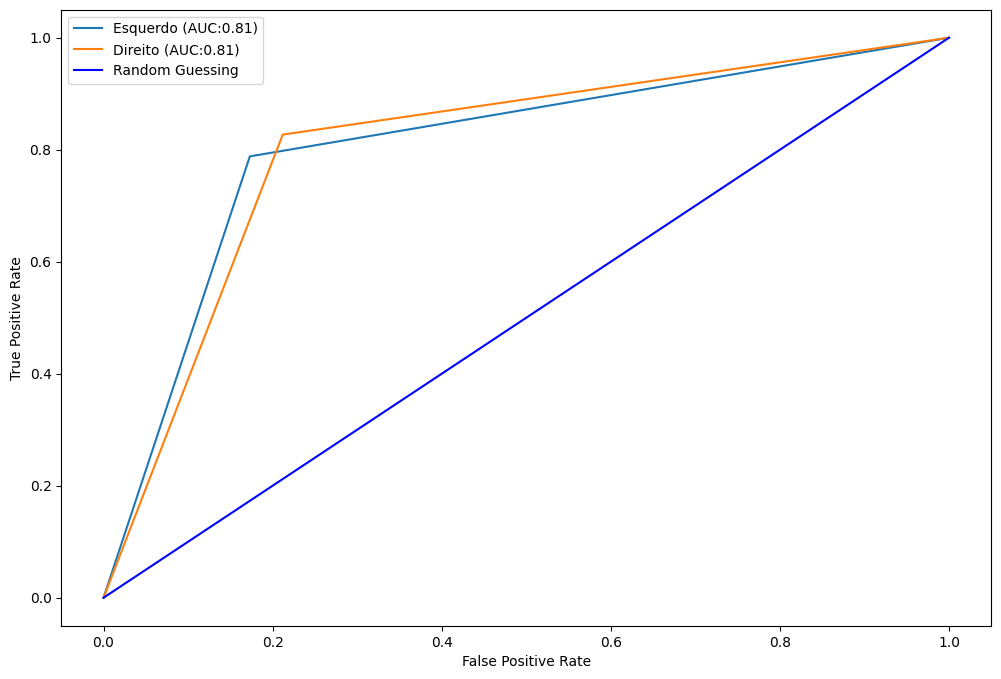

In [54]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score

target= ['Esquerdo','Direito']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        print(fpr, tpr, thresholds, auc(fpr, tpr))
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(labels_data, predicted_data))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [55]:
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score,f1_score

score = model.evaluate(physionetDataset.TrainDataset.x, physionetDataset.TrainDataset.y, verbose=0)

predicted = model.predict(physionetDataset.TrainDataset.x)
predicted = (predicted > 0.5)
labels_data = transform_data(physionetDataset.TrainDataset.y)
predicted_data = transform_data(predicted)


confusion_matrix = metrics.confusion_matrix(physionetDataset.TrainDataset.y, predicted)
precision = precision_score(physionetDataset.TrainDataset.y, predicted)
recall = recall_score(physionetDataset.TrainDataset.y, predicted)
f1 = f1_score(physionetDataset.TrainDataset.y, predicted)
print('Loss: ', score[0])
print('Accuracy: ', score[1])
print('Matriz de confusão: ', confusion_matrix)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1Score: ', f1)

89/89 [==============================] - 1s 6ms/step
Loss:  0.036960579454898834
Accuracy:  0.994358241558075
Matriz de confusão:  [[1416   11]
 [   5 1404]]
Precision:  0.992226148409894
Recall:  0.9964513839602555
F1Score:  0.9943342776203966


In [56]:
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score,f1_score

score = model.evaluate(physionetDataset.ValDataset.x, physionetDataset.ValDataset.y, verbose=0)

predicted = model.predict(physionetDataset.ValDataset.x)
predicted = (predicted > 0.5)
labels_data = transform_data(physionetDataset.ValDataset.y)
predicted_data = transform_data(predicted)


confusion_matrix = metrics.confusion_matrix(physionetDataset.ValDataset.y, predicted)
precision = precision_score(physionetDataset.ValDataset.y, predicted)
recall = recall_score(physionetDataset.ValDataset.y, predicted)
f1 = f1_score(physionetDataset.ValDataset.y, predicted)
print('Loss: ', score[0])
print('Accuracy: ', score[1])
print('Matriz de confusão: ', confusion_matrix)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1Score: ', f1)

20/20 [==============================] - 0s 6ms/step
Loss:  0.6276196837425232
Accuracy:  0.778491199016571
Matriz de confusão:  [[225  74]
 [ 64 260]]
Precision:  0.7784431137724551
Recall:  0.8024691358024691
F1Score:  0.790273556231003


In [230]:
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

<Axes: >

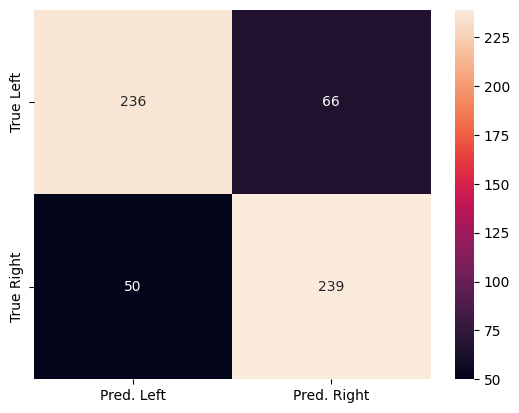

In [204]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[233,  69],
       [ 46, 243]]

df_cm = pd.DataFrame(array, index = ['True Left', 'True Right'],
                  columns = ['Pred. Left', 'Pred. Right'])

sn.heatmap(df_cm, annot=True, fmt='g')


In [ ]:
test_data
acc_by_subject = []
pacients = test_data["paciente"].unique()

for pacient in pacients:
  data_set = test_data[test_data["paciente"] == pacient]
  data_set = PhysionetDataset(data_set, selected_eletrodes, batch, train=False, std=train_dataset.std, mean=train_dataset.mean, normMinMax=train_dataset.norm)
  score = model.evaluate(data_set.features.x, data_set.features.y, verbose=0)
  acc_by_subject.append([pacient, score[1], len(data_set.features.x)])

(6, 640, 14)
(6,)


In [ ]:
acc_by_subject


# [93,83,27,45,55]

In [ ]:
train_data93 = train_data[(train_data["paciente"] == 93) | (train_data["paciente"] == 83)| (train_data["paciente"] == 27)| (train_data["paciente"] == 45)| (train_data["paciente"] == 55)]
val_data93 = val_data[(val_data["paciente"] == 93) | (val_data["paciente"] == 83)| (val_data["paciente"] == 27)| (val_data["paciente"] == 45)| (val_data["paciente"] == 55)]
test_data93 = test_data[(test_data["paciente"] == 93) | (test_data["paciente"] == 83)| (test_data["paciente"] == 27)| (test_data["paciente"] == 45)| (test_data["paciente"] == 55)]

In [ ]:
#[93, 0.25, 4],
train_data93 = PhysionetDataset(train_data93, selected_eletrodes, batch, train=False, std=train_dataset.std, mean=train_dataset.mean, normMinMax=train_dataset.norm)
val_data93 = PhysionetDataset(val_data93, selected_eletrodes, batch, train=False, std=train_dataset.std, mean=train_dataset.mean, normMinMax=train_dataset.norm)
test_data93 = PhysionetDataset(test_data93, selected_eletrodes, batch, train=False, std=train_dataset.std, mean=train_dataset.mean, normMinMax=train_dataset.norm)

(26, 640, 14)
(26,)


In [ ]:
print(train_data93.features.x.shape)
print(val_data93.features.x.shape)
print(test_data93.features.x.shape)

(164, 640, 14, 1)
(35, 640, 14, 1)
(26, 640, 14, 1)


In [ ]:
history = model.fit(train_data93.features.x, train_data93.features.y, epochs=10,
                    validation_data=(val_data93.features.x, val_data93.features.y))

Epoch 1/10
6/6 [==============================] - 2s 282ms/step - loss: 0.1727 - accuracy: 0.9146 - mse: 0.0565 - auc: 0.9925 - val_loss: 1.2235 - val_accuracy: 0.7143 - val_mse: 0.2465 - val_auc: 0.7067
Epoch 2/10
6/6 [==============================] - 2s 273ms/step - loss: 0.0769 - accuracy: 0.9756 - mse: 0.0189 - auc: 0.9993 - val_loss: 1.5370 - val_accuracy: 0.6571 - val_mse: 0.2756 - val_auc: 0.7150
Epoch 3/10
6/6 [==============================] - 2s 267ms/step - loss: 0.0336 - accuracy: 0.9939 - mse: 0.0081 - auc: 0.9994 - val_loss: 1.8388 - val_accuracy: 0.6857 - val_mse: 0.2810 - val_auc: 0.6917
Epoch 4/10
6/6 [==============================] - 2s 271ms/step - loss: 0.0159 - accuracy: 1.0000 - mse: 0.0028 - auc: 1.0000 - val_loss: 2.1608 - val_accuracy: 0.6857 - val_mse: 0.2887 - val_auc: 0.7183
Epoch 5/10
6/6 [==============================] - 2s 270ms/step - loss: 0.0222 - accuracy: 0.9878 - mse: 0.0065 - auc: 0.9999 - val_loss: 2.2789 - val_accuracy: 0.7429 - val_mse: 0.264

In [ ]:
score = model.evaluate(test_data93.features.x, test_data93.features.y, verbose=0)
print('Loss: ', score[0])
print('Accuracy: ', score[1])

Loss:  5.156682014465332
Accuracy:  0.5384615659713745


In [ ]:
acc_by_subject_test = []
pacients = test_data93["paciente"].unique()

for pacient in pacients:
  data_set = test_data93[test_data93["paciente"] == pacient]
  data_set = PhysionetDataset(data_set, selected_eletrodes, batch, train=False, std=train_dataset.std, mean=train_dataset.mean, normMinMax=train_dataset.norm)
  score = model.evaluate(data_set.features.x, data_set.features.y, verbose=0)
  acc_by_subject_test.append([pacient, score[1], len(data_set.features.x)])

(4, 640, 14)
(4,)


In [ ]:
acc_by_subject_test

[[27, 0.6666666865348816, 6],
 [45, 0.3333333432674408, 6],
 [55, 1.0, 4],
 [83, 0.5, 6],
 [93, 0.25, 4]]